Used to rename the files (and split the images into invidual channels) and add padding to make sure they are all the same size. Both of these things are needed to upload the images to TissueMAPS. This is supposed to be ran on images that have already been aligned with elastix.  
To make sure that there's absolutely no way that the original images are accidentally altered, I decided to do the renaming and padding in two steps. In the first step, copies of the images are renamed and split into individual channels. In the second step these images are cropped if needed and padding is added such that all images have the same dimensions.

In [32]:
from skimage import io
from PIL import Image
from pathlib import Path
import string
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity

## Renaming

In [24]:
def create_well_ids(nrows, ncols, n_wells):
    row_names = list(string.ascii_uppercase)[:nrows]
    well_names = ["{}{:02d}".format(row_name, col_name) for row_name in row_names for col_name in range(1,ncols+1)]
    return well_names[:n_wells]

In [25]:
# Define paths
path_plate = Path(r"/links/groups/treutlein/DATA/imaging/PW/4i/plate14/aligned")
path_renamed = Path(r"/links/groups/treutlein/DATA/imaging/PW/4i/plate14_aligned_renamed")

experiment_name = "plate14"

# Cycle names
cycles = ["cycle0", "cycle1", "cycle2", "cycle3", "cycle4", "cycle5",
         "cycle5_0", "cycle6", "cycle7", "cycle8", "cycle9", "cycle10",
         "cycle10_0", "cycle11", "cycle12", "cycle13", "cycle14", "cycle15",
         "cycle15_0", "cycle16", "cycle17", "cycle18", "cycle19", "cycle20",
         "cycle20_0", "cycle21", "cycle1_2", "cycle1_3"]

# Create list with all the IDs
points = ["00{:02d}".format(x) for x in range(74)]

# Define IDs to be excluded from analysis
points_bad = ["0000", "0001", "0005", "0009", "0033", "0036", "0037", "0038", 
              "0042", "0047", "0052", "0053", "0058", "0059", "0062", "0063", 
              "0064", "0065", "0066", "0067", "0068", "0069", "0070", "0073"]

# Remove "bad" points
points = [point for point in points if point not in points_bad]

TissueMAPS expects image IDs to be well names. We therefore need to define an artificial well with dimensions to fit all our images. For instance, using `nrows = 7` and `ncols = 8` will generate a plate with rows A to G and columns 01 to 08.

In [26]:
## Create dictionary that stores conversion of IDs to well coordinates
# Specify dimensions
nrows = 7
ncols = 8
n_wells = len(points)
# Get list with well names
wells = create_well_ids(nrows, ncols, n_wells)
# Create dict with point IDs as keys and corresponding well names as values
name_dict = dict(zip(points, wells))

To save time, images are only loaded and processed if the output file doesn't already exist. Since one multichannel input image is split into four single-channel output images, the script only checks if the first channel already exists. The only situation in which this could be a problem is if the program is aborted while renamed images are being saved. This would result in e.g. channels 3 and 4 not being saved but when re-running the program this would not be noticed since channel 1 is actually saved. But unless the script is interrupted, this should never be an issue.

In [11]:
for cycle in cycles:
    print("-"*10)
    print(cycle)
    Path(path_renamed/cycle).mkdir(parents=True, exist_ok=True)  # create output folder for current cycle
    for point in points:
        filename_in = "Point{}_{}.tif".format(point, cycle)  # original image
        well_name = name_dict[point]  # new nomenclature
        print("{} -> {}".format(point, well_name))
        
        # check if first channel output file already exist and skip if that's the case
        name_check = path_renamed/cycle/("{}_{}_C01.tif".format(experiment_name, well_name))
        if Path(name_check).is_file():
            print("Output file(s) already exists")
            continue
        
        # Load image and save the individual channels in the output folder
        try:
            img = io.imread(str(path_plate/("Point"+point)/cycle/filename_in))
            for chan in range(img.shape[2]):
                filename_out = "{}_{}_C{:02d}.tif".format(experiment_name, well_name, chan+1)
                io.imsave(str(path_renamed/cycle/filename_out), img[...,chan], check_contrast=False)
        except FileNotFoundError:
            print("\tCould not find Point{} of {}".format(point, cycle))

----------
cycle20
0000 -> A01
Output file already exists
0001 -> A02
Output file already exists
0002 -> A03
Output file already exists
0003 -> A04
Output file already exists
0004 -> A05
Output file already exists
0005 -> A06
Output file already exists
0006 -> A07
Output file already exists
0007 -> A08
Output file already exists
0008 -> A09
Output file already exists
0009 -> A10
Output file already exists
0010 -> A11
Output file already exists
0011 -> A12
Output file already exists
0012 -> A13
Output file already exists
0013 -> A14
Output file already exists
0014 -> A15
Output file already exists
0015 -> A16
Output file already exists
0016 -> A17
Output file already exists
0017 -> A18
Output file already exists
0018 -> A19
Output file already exists
0019 -> A20
Output file already exists
0020 -> A21
Output file already exists
0021 -> A22
Output file already exists
0022 -> A23
Output file already exists
0023 -> A24
Output file already exists
0024 -> B01
Output file already exists
0025 -

---  
## Resizing images  
TissueMaps needs all images to have the exact same dimensions. This means that we need to scan all images in the dataset, find the biggest one and add black pixels (padding) to the others. 

In [94]:
def rescale_image(img, min_quant=0, max_quant=0.98): 
    #img = img * 1.0 # turn type to float before rescaling
    min_val = np.quantile(img, min_quant)
    max_val = np.quantile(img, max_quant)
    img = rescale_intensity(img, in_range=(min_val, max_val))
    return img


def resize_img(img_old, x_new, y_new):
    img_y, img_x = img_old.shape  # get size of original image
    img_new = np.zeros((y_new, x_new), dtype=img_old.dtype)  # create empty image with new size
    img_new[0:img_y, 0:img_x] = img_old  # paste original image into corner of new one
    return img_new

In [100]:
# Define input and output paths
path_images = path_renamed  # images to be resized
path_resized = Path(r"/links/groups/treutlein/DATA/imaging/PW/4i/plate14_aligned_UZH")  # output directory for resized images

After the alignment with elastix any organoid image has the same size across all cycles. Therefore, when checking the sizes of the images we only need to check one cycle for each organoid.  
Since those IDs with missing cycles were removed from the `points` list it doesn't matter which cycle is used for this because all remaining organoids have an image for each cycle.   
**However**, for plate14 Point0071 and Point0072 are an exception: they are missing cycle1 but are still in the list. This is because the missing image will later on be replaced by cycle1_2. So, since we want to check the sizes of all the organoids, any cycle but cycle1 will work in this case.

In [85]:
# Pick a cycle that's present for all organoids
cycle = "cycle4"

# Check size of all images
x_vals = []
y_vals = []

for well in name_dict.values():
    filename = "{}_{}_C01.tif".format(experiment_name, well)  # only need to check first channel because all channels are of the same size
    try:
        img = Image.open(path_images/cycle/filename)
        img_x, img_y = img.size
        #print(well, (img_x, img_y))
        # Store x and y vals together with cycle and well number
        x_vals.append((well, img_x))
        y_vals.append((well, img_y))
    except:
        print("\t Well {} not found".format(well))

To check whether or not it's necessary to crop some of the images, we can sort them by size in x and y and print the top and bottom couple of entries for each. If the ones at the top are much larger than the ones at the bottom it's probably worth to crop a couple of images to save some space. Otherwise, the "Cropping" section below can be skipped.

In [86]:
# Sort by size
x_vals.sort(key=itemgetter(1), reverse=True)
y_vals.sort(key=itemgetter(1), reverse=True)

n_imgs = len(x_vals)

# Show top few images and then manually crop them below if necessary
print("{:^10}\t{:^10}".format("x_vals", "y_vals"))
for i in range(7):
    print("{:5}{:5}\t{:5}{:5}".format(x_vals[i][0], x_vals[i][1], y_vals[i][0], y_vals[i][1]))
for i in range(3):
    print("{:^10}\t{:^10}".format("...", "..."))
for i in range(n_imgs-7, n_imgs):
    print("{:5}{:5}\t{:5}{:5}".format(x_vals[i][0], x_vals[i][1], y_vals[i][0], y_vals[i][1]))

  x_vals  	  y_vals  
B01   7752	E05   7891
B04   7749	B04   7755
B08   7749	B08   7755
F02   7749	B01   7754
G02   7749	B03   7754
C02   7748	B05   7754
C07   7748	B06   7754
   ...    	   ...    
   ...    	   ...    
   ...    	   ...    
D03   7742	E01   7748
F06   7741	F05   7748
E01   7740	A08   7738
D07   7731	D03   7735
F08   7730	D08   7735
C03   7720	D04   7721
F05   7719	C03   7592


--- 
### Cropping (if necessary)

If some of the images are excessively large along one or both dimensions, it makes sense to crop them before adding padding in order to save disk space. This section allows for relatively quick cropping of the images listed above. It will iterate through the images ordered by size.  
Begin by **running the cell directly below once** and then continue.  
Also, in the line where the well is defined (close to the top of the cell) **make sure to pick *x_vals* or *y_vals* depending on which images you want to crop**.

In [88]:
# Run this cell only once at the start!
i = -1

This was just to make iterating through the images easier. As you can see further above, the images (or wells) that are largest along the x-axis are not necessarily at the top of the y-axis list, and vice versa. Therefore, we first need to define whether we want to start cropping the images large in x or y. Let's say that we want to focus on the images we deem "too large" along the x-axis first. In the very first line of the cell below, when defining the well we need to write use **x_vals**. This will then load the images largest in the x-dimension such that we can crop it, and in the next iteration it will load the second largest image in x and so on. If instead we want to focus on the y dimension, we need to **change x_vals to y_vals** before continuing.  
The following cell is used to load an example image and have a look at two of its cycles to roughly estimate how much we want to crop.

B01
(7754, 7752)


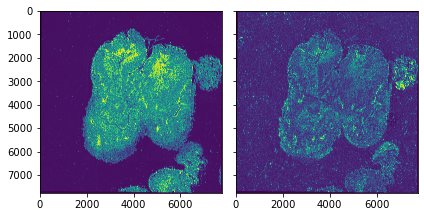

In [88]:
well = x_vals[i][0]  # change to x_vals or y_vals depending on which images you want to crop
i += 1  # jump to next image
print(well)

# Load images
nchan = 4  # number of channels per image
cycle = "cycle2"  # Any cycle is fine here
imgs = []
for chan in range(nchan):
    filename = "{}_{}_C{:02d}.tif".format(experiment_name, well, chan+1)
    img = io.imread((str(path_images/cycle/filename)))
    imgs.append(img)

# Show channels to see where the image can be cropped
fig, axes = plt.subplots(1,2, figsize=(6,6), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(rescale_image(imgs[0]))
ax[1].imshow(rescale_image(imgs[1]))
plt.tight_layout()
print(imgs[0].shape)

Now we need to define the borders for cropping. The parameters defined below are relatively self-explanatory. Just use the image above to estimate the right values. Don't worry, this can be adjusted several times because the final cropping happens later.  
Once the borders are defined, cycle1 and cycle21 are loaded, cropped and shown below. If the cropping makes sense, move on to the next cell. Otherwise, simply adjust the borders and try again.

cycle1
cycle21
cycle21 not found
cycle21 not found
cycle21 not found
cycle21 not found
(7754, 7752)


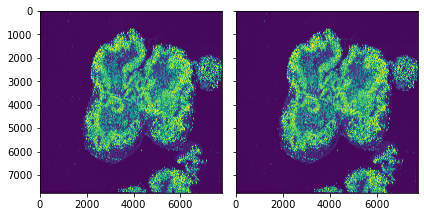

In [89]:
# Define borders for cropping
y_min = 0
y_max = imgs[0].shape[0]-0
x_min = 0
x_max = imgs[0].shape[1]-0

# Load first and last cycles
imgs = []
for cycle in ["cycle1", "cycle21"]:
    print(cycle)
    for chan in range(nchan):
        filename = "{}_{}_C{:02d}.tif".format(experiment_name, well, chan+1)
        try:
            img = io.imread((str(path_images/cycle/filename)))
            imgs.append(img)
        except:
            print("{} not found".format(cycle))

# Crop images
imgs_cropped = [img[y_min:y_max, x_min:x_max] for img in imgs]  # note that y comes first

# Check if cropping makes sense
fig, axes = plt.subplots(1,2, figsize=(6,6), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(rescale_image(imgs_cropped[2]))
ax[1].imshow(rescale_image(imgs_cropped[-2]))
plt.tight_layout()
print(imgs_cropped[0].shape)

If the cropping works for both the first and last cycle it's most likely safe to crop all cycles. The cell below will load all cycles, apply the cropping and overwrite the files.

In [55]:
# Load all cycles, crop images and overwrite them
for cycle in cycles:
    print(cycle)
    for chan in range(nchan):
        filename = "{}_{}_C{:02d}.tif".format(experiment_name, well, chan+1)
        img_path = str(path_images/cycle/filename)
        try:
            img = io.imread(img_path)
            img_cropped = img[y_min:y_max, x_min:x_max]  # note that y comes first
            io.imsave(img_path, img_cropped, check_contrast=False)
        except:
            print("{} not found".format(cycle))

cycle0
cycle1
cycle2
cycle3
cycle4
cycle5
cycle5_0
cycle6
cycle7
cycle8
cycle9
cycle10
cycle10_0
cycle11
cycle12
cycle13
cycle14
cycle15
cycle15_0
cycle16
cycle17
cycle18
cycle19
cycle20
cycle20_0
cycle21
cycle1_2
cycle1_3


To crop the next image, just go back to the start of the "Cropping" section. Once again, make sure you don't run the very first cell where `i` is set to -1. If you've reached a point where all images are of an adequate size and no longer want to crop more, just continue to the next section.   
If you were iterating through the images large in x and now want to go crop the images large in y, it's probably best to go to the very start of the "Resizing images" section and run those cells again. This is because more likely than not, some images large in x were also large in y so you probably cropped those in both dimensions. Therefore, it makes sense to check the sizes of all images again because the order might have changed.

--- 
### Resizing and saving

In case some images were cropped, run the cell below to get the final image sizes after cropping.

In [91]:
# Pick a cycle that's present for all organoids
cycle = "cycle4"

# Check size of all images
x_vals = []
y_vals = []

for well in name_dict.values():
    filename = "{}_{}_C01.tif".format(experiment_name, well)  # only need to check first channel because all channels are of the same size
    try:
        img = Image.open(path_images/cycle/filename)
        img_x, img_y = img.size
        #print(well, (img_x, img_y))
        # Store x and y vals together with cycle and well number
        x_vals.append((well, img_x))
        y_vals.append((well, img_y))
    except:
        print("\t Well {} not found".format(well))

In [92]:
# Get max x and y values
x_max = max(x_vals, key=itemgetter(1))[1]
y_max = max(y_vals, key=itemgetter(1))[1]
print((x_max, y_max))

(7752, 7891)


The last step is to add the padding to make sure all images have the same dimensions. The cell below will load the renamed images, add padding at the top and right borders if necessary, and save the final images in the output directory (`path_resized`) defined earlier.  
Loading and saving the images is done using the PIL package rather than skimage. This is because when saving PNG files, PIL.Image.save() allows the specification of the compression level which has an influence on the final file size. A larger compression level means smaller files, but saving them takes longer because more compression takes place. The compression level used by the skimage function `io.imsave()` is very large (and can't be lowered) meaning that saving the images will take forever.  
**Important:** Make sure you define the correct file format for the input images (currently ".tif").

In [ ]:
nchan = 4  # number of channels per image
for cycle in cycles:
    print(cycle)
    Path(path_resized/cycle).mkdir(parents=True, exist_ok=True)
    for well in name_dict.values():
        print("\t", well)
        for chan in range(nchan):
            filename_in = "{}_{}_C{:02d}.tif".format(experiment_name, well, chan+1)
            filename_out = "{}_{}_C{:02d}.png".format(experiment_name, well, chan+1)
            if Path(path_resized/cycle/filename_out).is_file():  # Check if output file already exists
                print("Output file already exists")
                continue
            try:
                img = Image.open(path_images/cycle/filename_in)  # load image
                img = np.asarray(img)  #  turn image to np array
                img_new = resize_img(img, x_max, y_max)  # resize
                img_new = Image.fromarray(img_new)  # turn into image again
                img_new.save(path_resized/cycle/filename_out, compress_level=6)  # save new image
            except FileNotFoundError:
                print("\t{} not found".format(filename_in))

cycle0
	 A01
	 A02
	 A03
	 A04
	 A05
	 A06
	 A07
	 A08
	 B01
	 B02
	 B03
	 B04
	 B05
	 B06
	 B07
	 B08
	 C01
	 C02
	 C03
	 C04
	 C05
	 C06
	 C07
	 C08
	 D01
	 D02
	 D03
	 D04
	 D05
	 D06
	 D07
	 D08
	 E01
	 E02
	 E03
	 E04
	 E05
	 E06
	 E07
	 E08
	 F01
	 F02
	 F03
	 F04
	 F05
	 F06


We now have a folder containing images that are both renamed and have padding. However, we also still have the folder with the images that were only renamed and lack the padding (`path_renamed`). To save disk space, it's probably best to just delete this folder because it's no longer needed.